In [2]:
import numpy as np
from time import sleep
import gym
import random
import matplotlib.pyplot as plt

In [3]:
env = gym.make('CartPole-v0')
print("Action space: ", env.action_space.n)
print("State space: ", env.observation_space.shape[0])

Action space:  2
State space:  4


In [4]:
def discretize_state(state, bins):
	discretized = []
	for i in range(len(state)):
		discretized.append(np.digitize(state[i], bins[i]) - 1)
	return tuple(discretized)

In [5]:
bins = [np.linspace(-4.8, 4.8, 30),
		np.linspace(-4,4, 30),
		np.linspace(-0.418, 0.418, 30),
		np.linspace(-4,4, 30)]
	


q_table = np.random.uniform(low=-1, high = 1, size=([30] * 4 + [2]))

lr = 0.15
gamma = 0.99
epsilon = 0.1

all_epochs = []
all_penalties = []

print(q_table.shape)

(30, 30, 30, 30, 2)


In [6]:
for i in range(1, 5000):
	state = discretize_state(env.reset(), bins)

	epochs, reward = 0,0
	action = -1
	done  = False
	while not done:
		if(random.uniform(0, 1) < epsilon):
			action = env.action_space.sample()
		else:
			action = np.argmax(q_table[state])
		
		next_state, reward, done, info = env.step(action)
		next_state = discretize_state(next_state, bins)
		
		old_value = q_table[state + (action, )]
		next_max = np.max(q_table[next_state])
		new_value = (1-lr)*old_value + lr * (reward + gamma * next_max )
		q_table[state + (action, )] = new_value
		
		state = next_state
		epochs +=1
	
	
	all_epochs.append(epochs)

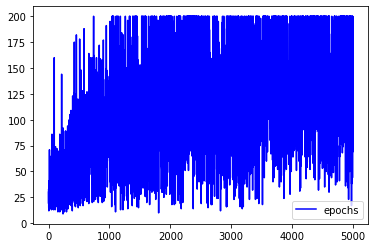

In [7]:
plt.plot(all_epochs, c='blue', label='epochs')
plt.legend()

In [8]:
# Evaluation
episodes = 100
total_epochs = 0

for i in range(episodes):
	state = discretize_state(env.reset(), bins)

	epochs, reward = 0,0
	done  = False
	while not done:
		action = np.argmax(q_table[state])
		state, reward, done, info = env.step(action)
		state = discretize_state(state, bins)
		epochs += 1
		if(i == episodes -1):
			env.render()
			sleep(0.01)
	total_epochs += epochs

	

env.close()

print(f"Results after {episodes} episodes")
print(f"Average epochs per run: {round(total_epochs/episodes,3)}")

Results after 100 episodes
Average epochs per run: 163.45
